# Nameraná šírka pásma siete
```bash
pi@malina:~ $  iperf -s
miroslav@ThinkPad: ~ $ iperf -i 1 -c 192.168.0.2
```
**Bandwidth: 94.2 Mbit/sec**

#### Sieťová premávka vytvorená útokmi záplavou

**Nástroje:** `hping`, `wireshark`, `vnstat`, `curl`

+ Obeť: `vnstat --trafic`
+ Klient: `curl -I 192.168.0.2`

# UDP flood
```bash
(attacker) hping 192.168.0.2 --udp --flood
```
```text
736735 packets sampled in 5 seconds
Traffic average for eth0
      rx           54,22 Mbit/s          147345 packets/s
      tx            0,86 kbit/s          1 packets/s
```

# ICMP Flood
```bash
(attacker) hping 192.168.0.2 --icmp --flood
```
```text
hping 192.168.0.2 --icmp --flood
640086 packets sampled in 5 seconds
Traffic average for eth0
      rx           45,07 Mbit/s           122483 packets/s
      tx            2,21 Mbit/s           5534 packets/s
```

### ICMP Flood s podvrhnutou existujúcou IP
```bash
(attacker) hping 192.168.0.2 --icmp --flood --spoof 192.168.0.3
```
```text
640086 packets sampled in 5 seconds
Traffic average for eth0
      rx           45,46 Mbit/s           123540 packets/s
      tx            2,20 Mbit/s           5498 packets/s

```

### ICMP Flood s podvrhnutou neplatnou IP
```bash
(attacker) hping 192.168.0.2 --icmp --flood --spoof 192.168.0.20
```
```text
717771 packets sampled in 5 seconds
Traffic average for eth0
      rx           52,83 Mbit/s           143533 packets/s
      tx            0,32 kbit/s           0 packets/s
```

# HTTP premávka - záťažové testy Apache Bench

### HAProxy nastavenie vyvažovania záťaže (balance) a počtu uzlov
roundrobin(1, 2, 3), leastconn(2, 3), source(2, 3), roundrobin weight(3)

```bash
ab -n 10 -c 1 http://192.168.0.2:8080/ > ab_10_1.txt
ab -n 100 -c 10 http://192.168.0.2:8080/ > ab_100_10.txt
ab -n 1000 -c 100 http://192.168.0.2:8080/ > ab_1000_100.txt
ab -n 10000 -c 1000 http://192.168.0.2:8080/ > ab_10000_1000.txt
```

# Analýza logov

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as mplt
import re
import os

def haproxy_experiment(name):
    log = pd.read_csv(
        name, 
        header=None,
        usecols=[6, 8, 9, 15, 16],
        names=['timestamp', 'destination', 'timers', 'connections', 'queues'],
        sep='\s+'
    )

    log[['TR', 'Tw', 'Tc', 'Tr', 'Ta']] = log['timers'].str.split('/', expand=True).apply(pd.to_numeric)
    log[['summary', 'frontend', 'backend', 'server', 'retry']] = log['connections'].str.split('/', expand=True).apply(pd.to_numeric)
    log[['srv_queue', 'backend_queue']] = log['queues'].str.split('/', expand=True).apply(pd.to_numeric)

    log['timestamp'] = pd.to_datetime(log['timestamp'], format='[%d/%b/%Y:%H:%M:%S.%f]')
    log['destination'] = log['destination'].replace(r'^\w+/(\w+)$', r'\1', regex=True)
    log = log[log['destination'].str.contains(r'^[A-Z]$', regex=True)]

    log['time_diff'] = (log['timestamp'] - log['timestamp'][0]).astype('timedelta64[ms]')
    log = log.sort_values(by=['time_diff'])
    log['servers_mean'] = log['server'].rolling(10).mean()
    log.replace(-1, 0, inplace=True)

    del log['timers']
    del log['connections']
    del log['queues']
    
    return log

def haproxy_timers(dataset, name):
    plt = dataset.plot(
        x='time_diff', y=['TR', 'Tw', 'Tc', 'Tr'],
        title='HAProxy časovače', 
        kind='area', grid=True,
    )
    plt.set_xlabel('Čas [ms]')
    plt.set_ylabel('Trvanie požiadavky [ms]')
    
def plot_haproxy_log(dataset, name):
    fig, axes = mplt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    a = dataset.plot(
        x='time_diff', y=['summary', 'servers_mean'], title='HTTP spojenia', 
        grid=True,
        ax=axes[0]
    )
    a.set_xlabel('Čas [ms]')
    a.set_ylabel('Počet aktívnych spojení')
    
    b = dataset.plot(
        x='time_diff', y=['TR', 'Tw', 'Tc', 'Tr'], # TR to comparaison plot between methods
        title='HAProxy časovače', 
        kind='area', grid=True,
        ax=axes[1]
    )
    b.set_xlabel('Čas [ms]')
    b.set_ylabel('Trvanie požiadavky [ms]')
    fig.suptitle(name)
    
def scheduling_matrix(dataset):
    # Matica pravdepodobnosti prechodov plánovania
    row_count = len(dataset.index) - 1
    servers = sorted(dataset['destination'].unique())
    dataset['next_dst'] = dataset['destination'].shift(-1)
    groups = dataset.groupby(['destination', 'next_dst'])
    
    counts = {g[0]: len(g[1]) for g in groups}
    matrix = pd.DataFrame()
    for s in servers:
        matrix[s] = pd.Series([counts.get((s, y), 0) / row_count for y in servers], index=servers)
    matrix = matrix.style.background_gradient(cmap='Blues')
    return matrix

def ab_stats(file):
    # files = ['ab_10_1.txt', 'ab_100_10.txt', 'ab_1000_100.txt', 'ab_10000_1000.txt']
    folders = [
        'roundrobin-1',
        'roundrobin-2', 'leastconn-2', 'source-2',
        'roundrobin-3', 'leastconn-3','source-3', 'roundrobin-weights'
    ]
    tests = pd.DataFrame(
        columns=[
            'duration', 'complete_requests', 'req_per_sec', 'transfer_rate', 
            'connection_mean', 'connection_sd'
        ]
    )

    for folder in folders:
        measurement = {}
        with open(os.path.join(folder, file), 'r') as ab:
            for line in ab:
                if (m := re.search(r'Time taken for tests:\s+(\d*\.?\d*)', line)):
                    measurement['duration'] = m.group(1)
                elif (m := re.search('Complete requests:\s+(\d+)', line)):
                    measurement['complete_requests'] = m.group(1)
                elif (m := re.search('Requests per second:\s+(\d*\.?\d*)', line)):
                    measurement['req_per_sec'] = m.group(1)
                elif (m := re.search('Transfer rate:\s+(\d*\.?\d*)', line)):
                    measurement['transfer_rate'] = m.group(1)
                elif (m := re.search('Total:\s+\d+\s*(\d+)\s+(\d*\.?\d*)', line)):
                    measurement['connection_mean'] = m.group(1)
                    measurement['connection_sd'] = m.group(2)
        tests = tests.append(pd.Series(measurement, name=folder))

    tests['req_per_sec'] = tests['req_per_sec'].apply(pd.to_numeric)
    tests['connection_mean'] = tests['connection_mean'].apply(pd.to_numeric)
    tests['connection_sd'] = tests['connection_sd'].apply(pd.to_numeric)

    return tests  

def ab_plot(b, fieldname):
    algo = pd.DataFrame(columns=['nodes', 'roundrobin', 'leastconn', 'source'])
    for n in range(1, 4):
        if n == 1:
            stats = {'nodes': n, 'roundrobin': b.at[f'roundrobin-{n}', fieldname], 'leastconn': 0, 'source': 0}
        else:
            stats = pd.Series({
                'nodes': n,
                'roundrobin': b.at[f'roundrobin-{n}', fieldname], 
                'leastconn': b.at[f'leastconn-{n}', fieldname], 
                'source': b.at[f'source-{n}', fieldname]
            })
        algo = algo.append(stats, ignore_index=True)
        
    return algo
    
def ab_request_frequency_plot(benchmark):
    algo = ab_plot(benchmark, 'req_per_sec')
    plt = algo.plot(x='nodes', y=['roundrobin', 'leastconn', 'source'],
                    title='Požiadavky za sekundu', figsize=(10, 5), grid=True, kind='bar')
    plt.set_xlabel('Počet uzlov')
    plt.set_ylabel('Počet požiadaviek za sekundu')
    
def ab_connection_mean(benchmark):
    algo = ab_plot(benchmark, 'connection_mean')
    std = ab_plot(benchmark, 'connection_sd')
    
    plt = algo.plot.bar(x='nodes', y=['roundrobin', 'leastconn', 'source'],
                    title='Trvanie spojenia', figsize=(10, 5), grid=True, 
                    yerr=std[['roundrobin', 'leastconn', 'source']].T.values)
    plt.set_xlabel('Počet uzlov')
    plt.set_ylabel('Priemerné trvanie požiadavky [ms]')


# TODO: HAProxy timers average TR compare within request counts
# TODO: Draw network/markov chain


Bad key text.latex.unicode in file /usr/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /usr/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /usr/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotl

---
# ApacheBench (10 spojení, 1 paralelne)

In [2]:
benchmark = ab_stats('ab_10_1.txt')
benchmark

,duration,complete_requests,req_per_sec,transfer_rate,connection_mean,connection_sd
roundrobin-1,0.151,10,66.43,188.09,15,1.7
roundrobin-2,0.158,10,63.41,177.88,16,1.5
leastconn-2,0.160,10,62.37,175.48,16,1.7
source-2,0.161,10,62.16,175.31,16,1.8
roundrobin-3,0.204,10,49.04,137.86,20,7.7
leastconn-3,0.208,10,48.10,135.00,21,8.2
source-3,0.191,10,52.48,147.95,19,1.5
roundrobin-weights,0.154,10,65.05,184.19,15,1.2


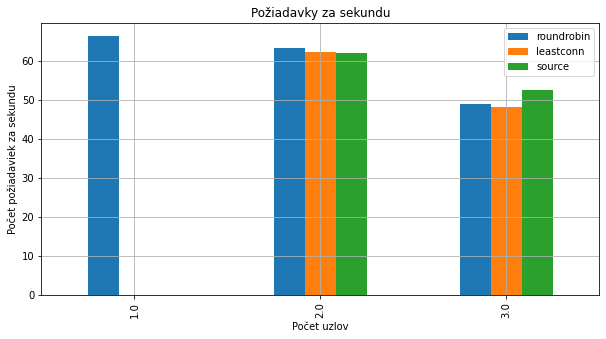

In [3]:
ab_request_frequency_plot(benchmark)

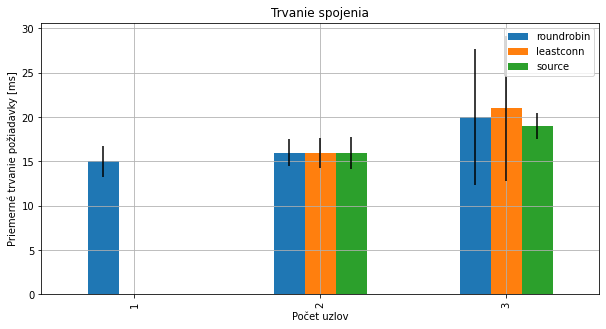

In [4]:
ab_connection_mean(benchmark)

# ApacheBench (100 spojení, 10 paralelne)

In [5]:
benchmark = ab_stats('ab_100_10.txt')
benchmark

,duration,complete_requests,req_per_sec,transfer_rate,connection_mean,connection_sd
roundrobin-1,0.363,100,275.80,776.79,33,10.4
roundrobin-2,0.248,100,403.64,1136.57,23,8.6
leastconn-2,0.268,100,372.77,1048.76,25,10.3
source-2,0.311,100,321.31,903.09,29,12.1
roundrobin-3,0.240,100,416.49,1171.28,22,10.9
leastconn-3,0.227,100,439.89,1239.99,21,8.3
source-3,0.443,100,225.49,634.67,41,17.2
roundrobin-weights,0.278,100,359.57,1012.17,25,11.7


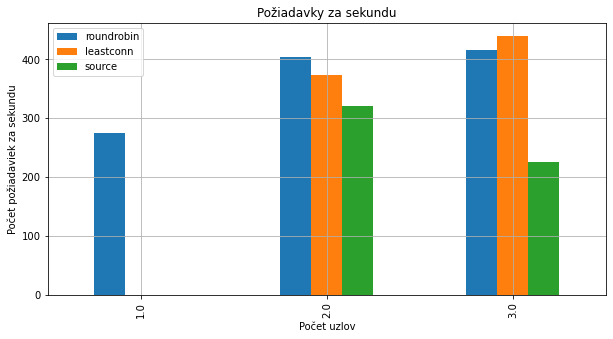

In [6]:
ab_request_frequency_plot(benchmark)

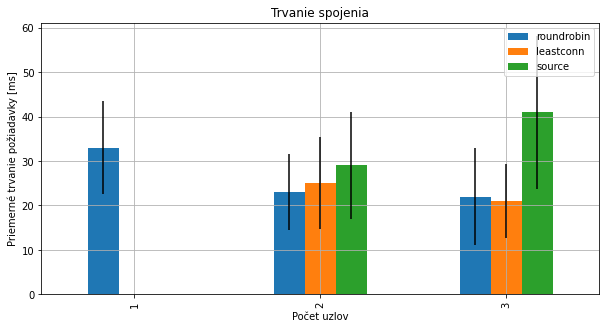

In [7]:
ab_connection_mean(benchmark)

# ApacheBench (1000 spojení, 100 paralelne)

In [8]:
benchmark = ab_stats('ab_1000_100.txt')
benchmark

,duration,complete_requests,req_per_sec,transfer_rate,connection_mean,connection_sd
roundrobin-1,3.455,1000,289.47,814.60,330,67.5
roundrobin-2,2.006,1000,498.53,1402.64,185,154.1
leastconn-2,1.679,1000,595.63,1676.04,156,69.8
source-2,2.471,1000,404.70,1138.62,234,30.4
roundrobin-3,1.578,1000,633.59,1782.31,144,93.2
leastconn-3,1.476,1000,677.49,1906.25,141,32.4
source-3,4.227,1000,236.55,665.66,403,64.0
roundrobin-weights,2.328,1000,429.59,1208.40,216,152.9


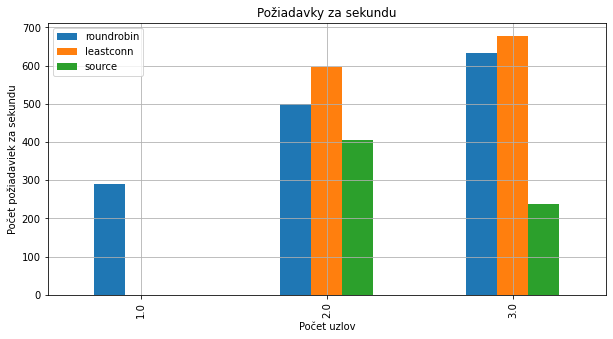

In [9]:
ab_request_frequency_plot(benchmark)

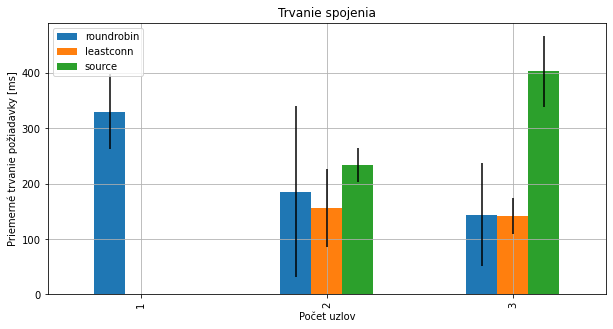

In [10]:
ab_connection_mean(benchmark)

# ApacheBench (10000 spojení, 1000 paralelne)

In [11]:
benchmark = ab_stats('ab_10000_1000.txt')
benchmark

,duration,complete_requests,req_per_sec,transfer_rate,connection_mean,connection_sd
roundrobin-1,42.186,10000,237.05,645.94,3129,5418.3
roundrobin-2,30.413,10000,328.81,924.92,1865,2904.1
leastconn-2,16.500,10000,606.08,1704.95,1549,543.8
source-2,34.079,10000,293.44,801.17,2559,5273.0
roundrobin-3,15.129,10000,660.99,1859.64,1393,759.1
leastconn-3,12.668,10000,789.42,2220.62,1192,424.6
source-3,46.984,10000,212.84,588.04,3931,4706.0
roundrobin-weights,32.724,10000,305.59,859.53,2344,4418.1


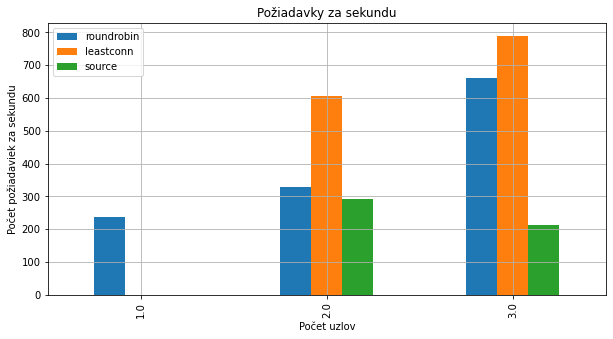

In [12]:
ab_request_frequency_plot(benchmark)

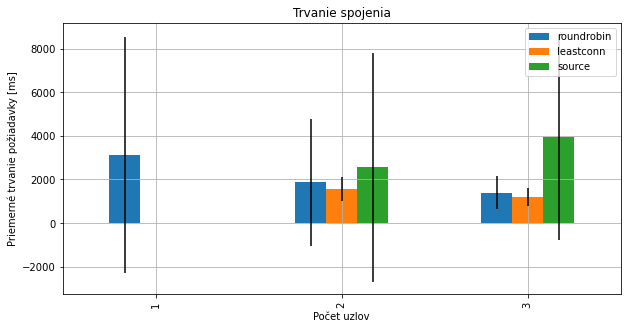

In [13]:
ab_connection_mean(benchmark)

---
# HAProxy (10 spojení, 1 paralelne)

In [14]:
log = haproxy_experiment('roundrobin-1/haproxy_ab_10_1.log')
scheduling_matrix(log)

,A
A,1.000000


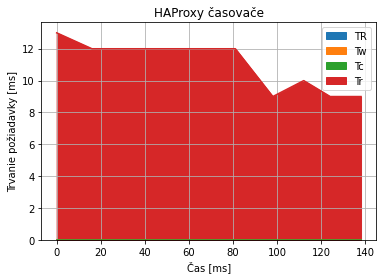

In [15]:
haproxy_timers(log, 'Round Robin (1 uzol)')

In [16]:
log = haproxy_experiment('roundrobin-2/haproxy_ab_10_1.log')
scheduling_matrix(log)

,A,B
A,0.000000,0.444444
B,0.555556,0.000000


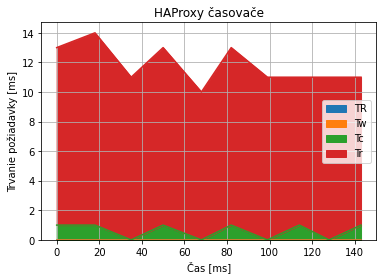

In [17]:
haproxy_timers(log, 'Round Robin (2 uzly)')

In [18]:
log = haproxy_experiment('roundrobin-3/haproxy_ab_10_1.log')
scheduling_matrix(log)

,A,B,C
A,0.000000,0.000000,0.333333
B,0.333333,0.000000,0.000000
C,0.000000,0.333333,0.000000


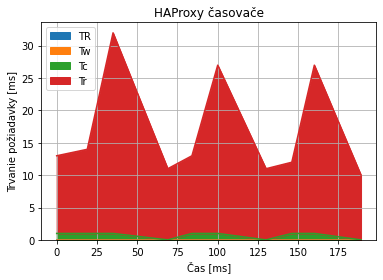

In [19]:
haproxy_timers(log, 'Round Robin (3 uzly)')

In [20]:
log = haproxy_experiment('roundrobin-weights/haproxy_ab_10_1.log')
scheduling_matrix(log)

,A,B
A,0.333333,0.333333
B,0.333333,0.000000


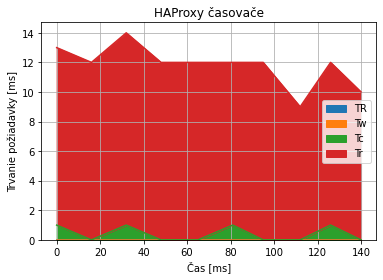

In [21]:
haproxy_timers(log, 'Round Robin (3 uzly, váhy: 10, 5, 1)')

In [22]:
log = haproxy_experiment('leastconn-2/haproxy_ab_10_1.log')
scheduling_matrix(log)

,A,B
A,0.000000,0.444444
B,0.555556,0.000000


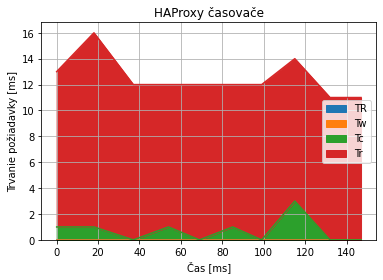

In [23]:
haproxy_timers(log, 'Least connections (2 uzly)')

In [24]:
log = haproxy_experiment('leastconn-3/haproxy_ab_10_1.log')
scheduling_matrix(log)

,A,B,C
A,0.000000,0.000000,0.333333
B,0.333333,0.000000,0.000000
C,0.000000,0.333333,0.000000


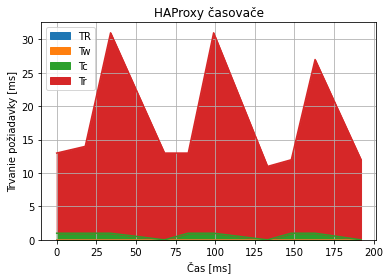

In [25]:
haproxy_timers(log, 'Least connections (3 uzly)')

In [26]:
log = haproxy_experiment('source-2/haproxy_ab_10_1.log')
scheduling_matrix(log)

,B
B,1.000000


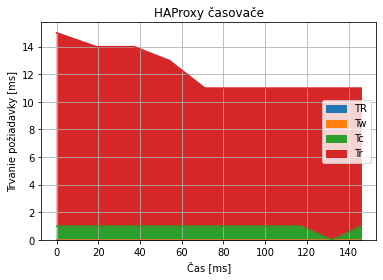

In [27]:
haproxy_timers(log, 'Source (2 uzly)')

In [28]:
log = haproxy_experiment('source-3/haproxy_ab_10_1.log')
scheduling_matrix(log)

,C
C,1.000000


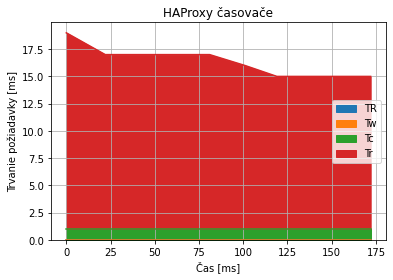

In [29]:
haproxy_timers(log, 'Source (3 uzly)')

---
# HAProxy (100 spojení, 10 paralelne)

In [30]:
log = haproxy_experiment('roundrobin-1/haproxy_ab_100_10.log')
scheduling_matrix(log)

,A
A,1.000000


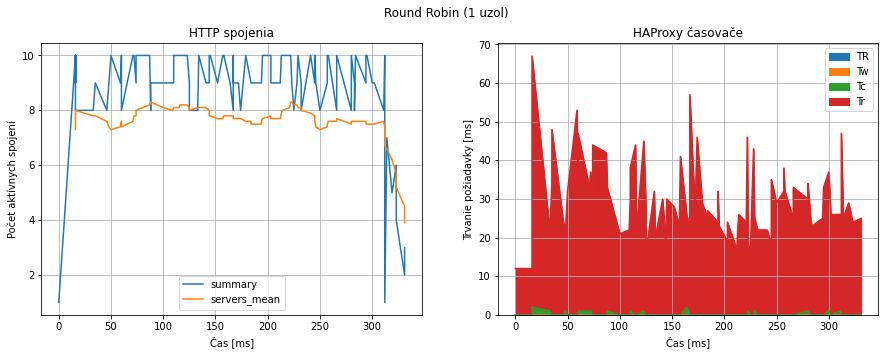

In [31]:
plot_haproxy_log(log, 'Round Robin (1 uzol)')

In [32]:
log = haproxy_experiment('roundrobin-2/haproxy_ab_100_10.log')
scheduling_matrix(log)

,A,B
A,0.151515,0.343434
B,0.353535,0.151515


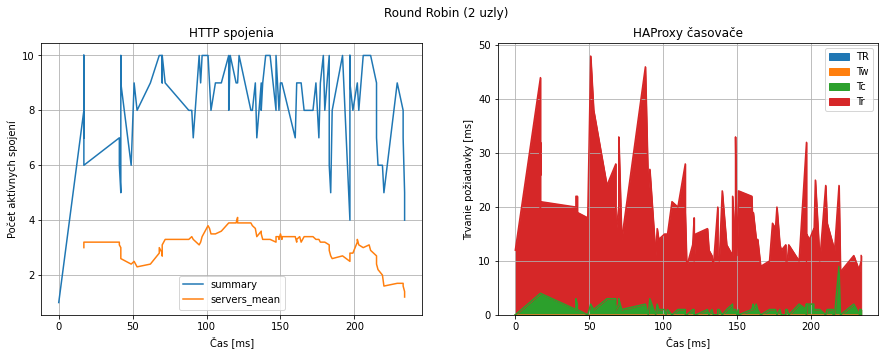

In [33]:
plot_haproxy_log(log, 'Round Robin (2 uzly)')

In [34]:
log = haproxy_experiment('roundrobin-3/haproxy_ab_100_10.log')
scheduling_matrix(log)

,A,B,C
A,0.030303,0.131313,0.171717
B,0.202020,0.010101,0.121212
C,0.101010,0.191919,0.040404


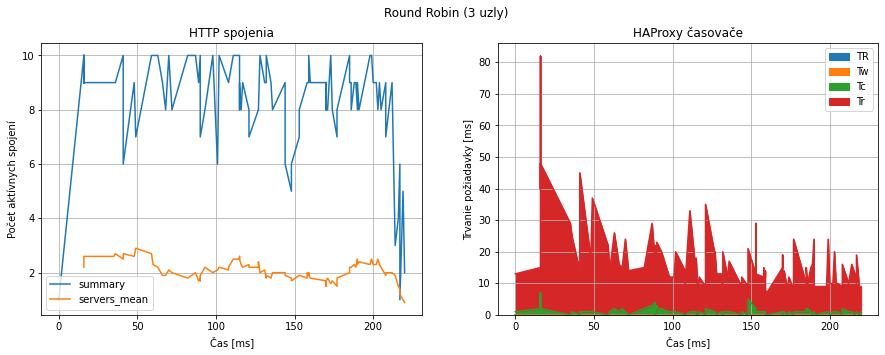

In [35]:
plot_haproxy_log(log, 'Round Robin (3 uzly)')

In [36]:
log = haproxy_experiment('roundrobin-weights/haproxy_ab_100_10.log')
scheduling_matrix(log)

,A,B,C
A,0.313131,0.252525,0.060606
B,0.272727,0.040404,0.000000
C,0.040404,0.020202,0.000000


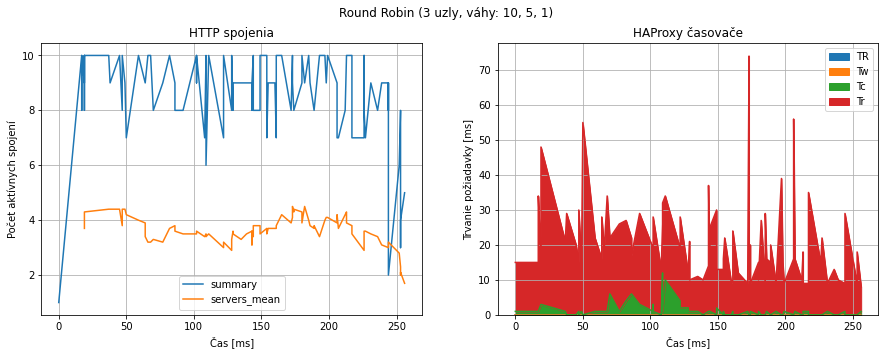

In [37]:
plot_haproxy_log(log, 'Round Robin (3 uzly, váhy: 10, 5, 1)')

In [38]:
log = haproxy_experiment('leastconn-2/haproxy_ab_100_10.log')
scheduling_matrix(log)

,A,B
A,0.171717,0.333333
B,0.333333,0.161616


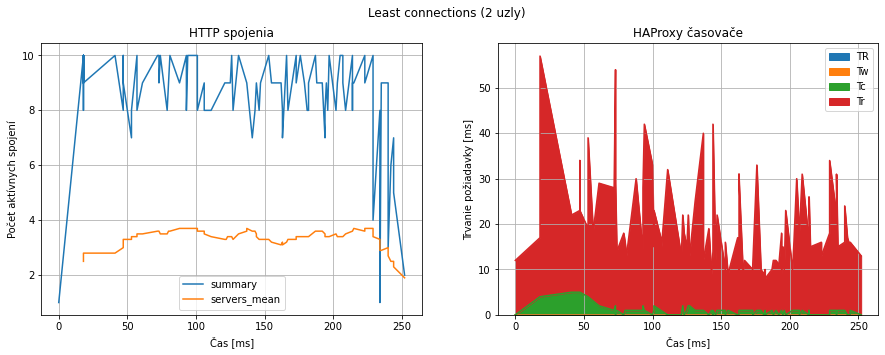

In [39]:
plot_haproxy_log(log, 'Least connections (2 uzly)')

In [40]:
log = haproxy_experiment('leastconn-3/haproxy_ab_100_10.log')
scheduling_matrix(log)

,A,B,C
A,0.080808,0.191919,0.090909
B,0.161616,0.070707,0.141414
C,0.111111,0.121212,0.030303


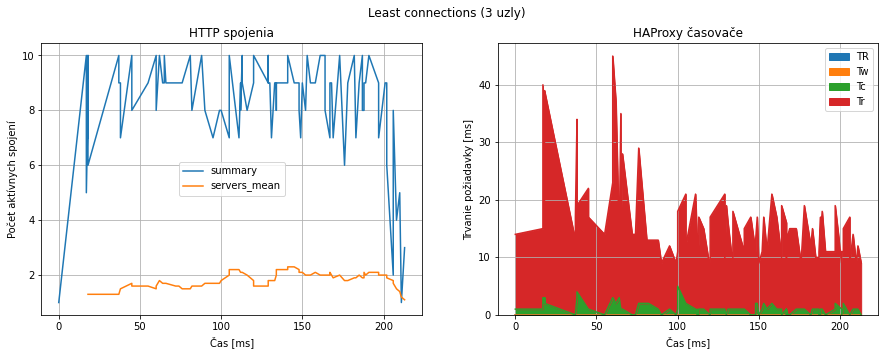

In [41]:
plot_haproxy_log(log, 'Least connections (3 uzly)')

In [42]:
log = haproxy_experiment('source-2/haproxy_ab_100_10.log')
scheduling_matrix(log)

,B
B,1.000000


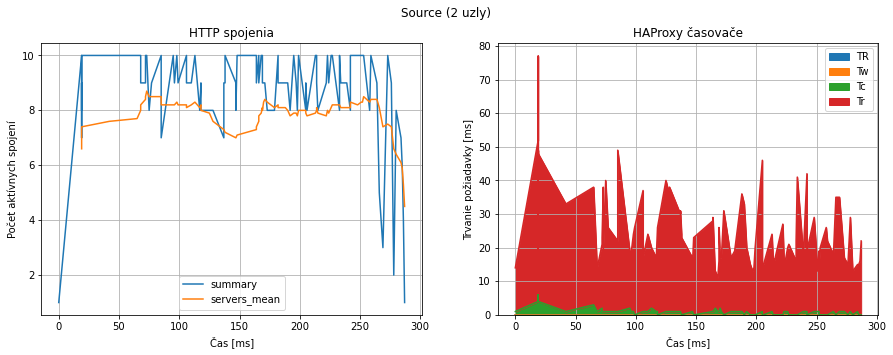

In [43]:
plot_haproxy_log(log, 'Source (2 uzly)')

In [44]:
log = haproxy_experiment('source-3/haproxy_ab_100_10.log')
scheduling_matrix(log)

,C
C,1.000000


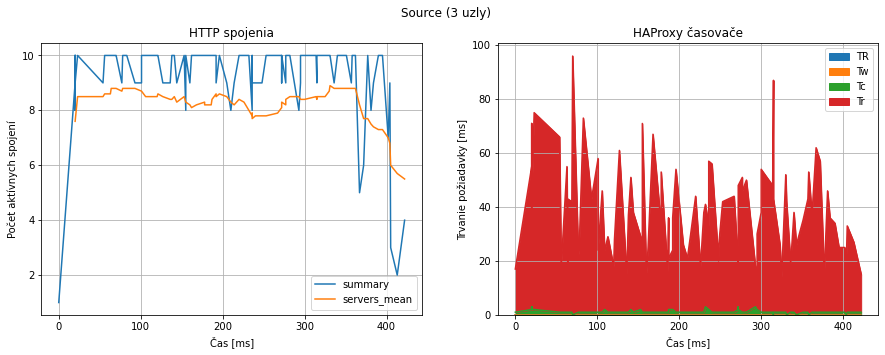

In [45]:
plot_haproxy_log(log, 'Source (3 uzly)')

---
# HAProxy (1000 spojení, 100 paralelne)

In [46]:
log = haproxy_experiment('roundrobin-1/haproxy_ab_1000_100.log')
scheduling_matrix(log)

,A
A,1.000000


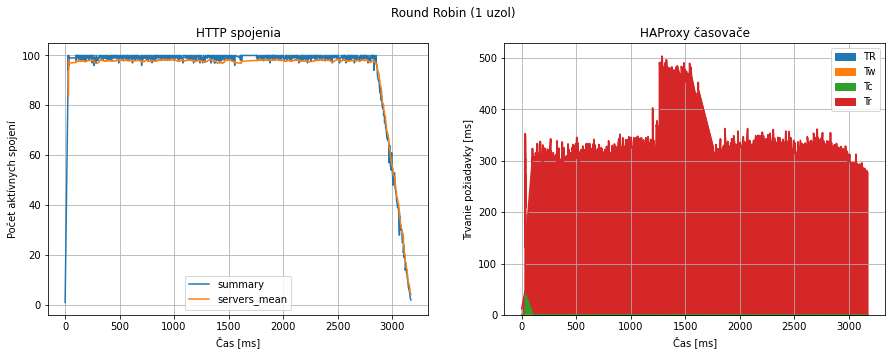

In [47]:
plot_haproxy_log(log, 'Round Robin (1 uzol)')

In [48]:
log = haproxy_experiment('roundrobin-2/haproxy_ab_1000_100.log')
scheduling_matrix(log)

,A,B
A,0.124124,0.375375
B,0.376376,0.124124


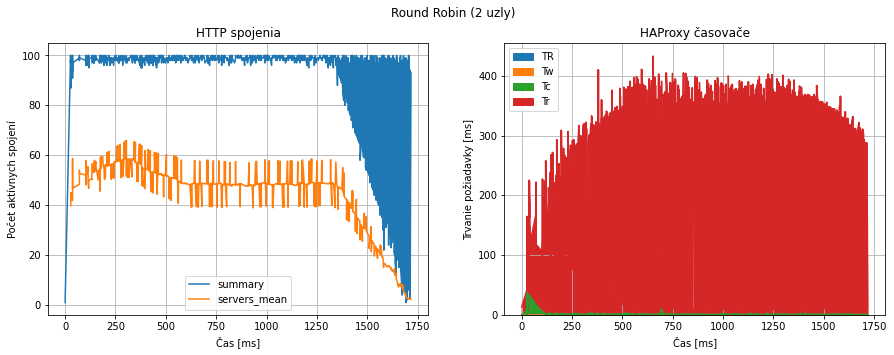

In [49]:
plot_haproxy_log(log, 'Round Robin (2 uzly)')

In [50]:
log = haproxy_experiment('roundrobin-3/haproxy_ab_1000_100.log')
scheduling_matrix(log)

,A,B,C
A,0.039039,0.122122,0.172172
B,0.170170,0.040040,0.123123
C,0.124124,0.171171,0.038038


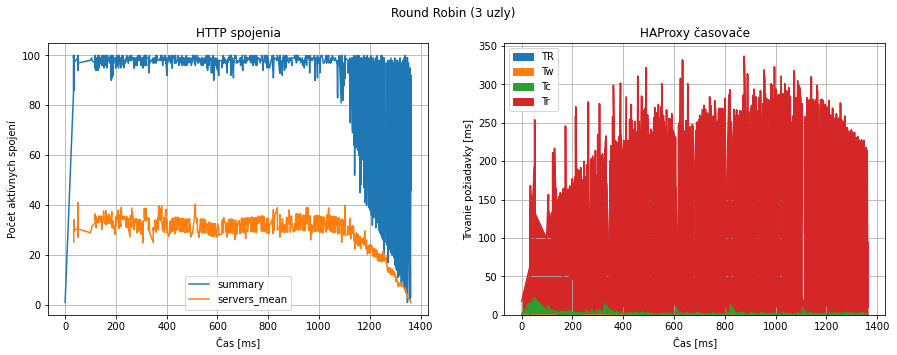

In [51]:
plot_haproxy_log(log, 'Round Robin (3 uzly)')

In [52]:
log = haproxy_experiment('roundrobin-weights/haproxy_ab_1000_100.log')
scheduling_matrix(log)

,A,B,C
A,0.325325,0.250250,0.049049
B,0.250250,0.049049,0.013013
C,0.049049,0.013013,0.001001


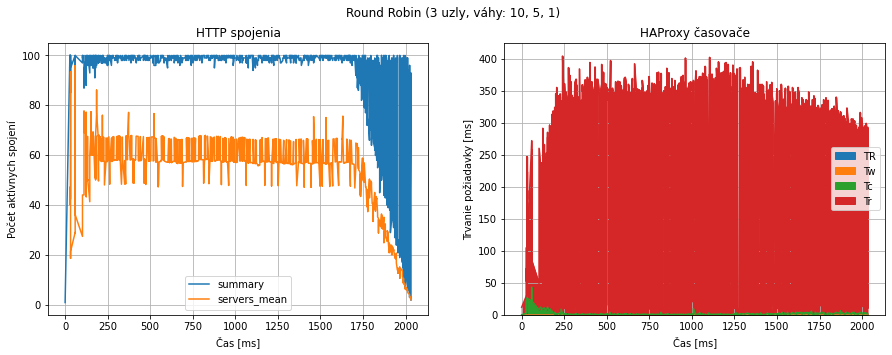

In [53]:
plot_haproxy_log(log, 'Round Robin (3 uzly, váhy: 10, 5, 1)')

In [54]:
log = haproxy_experiment('leastconn-2/haproxy_ab_1000_100.log')
scheduling_matrix(log)

,A,B
A,0.106106,0.260260
B,0.260260,0.373373


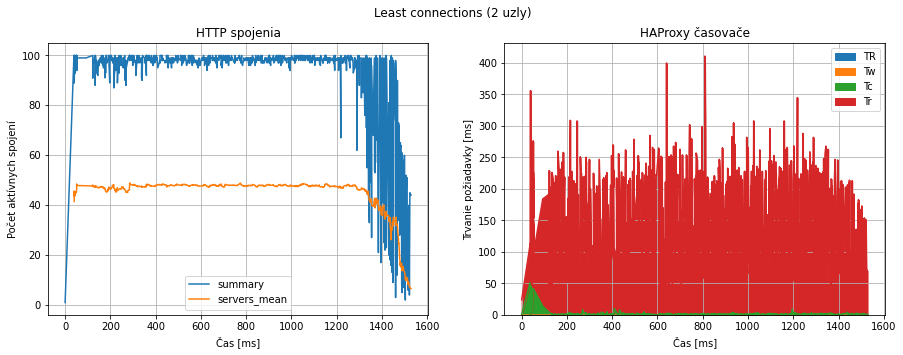

In [55]:
plot_haproxy_log(log, 'Least connections (2 uzly)')

In [56]:
log = haproxy_experiment('leastconn-3/haproxy_ab_1000_100.log')
scheduling_matrix(log)

,A,B,C
A,0.082082,0.171171,0.097097
B,0.159159,0.122122,0.069069
C,0.108108,0.057057,0.134134


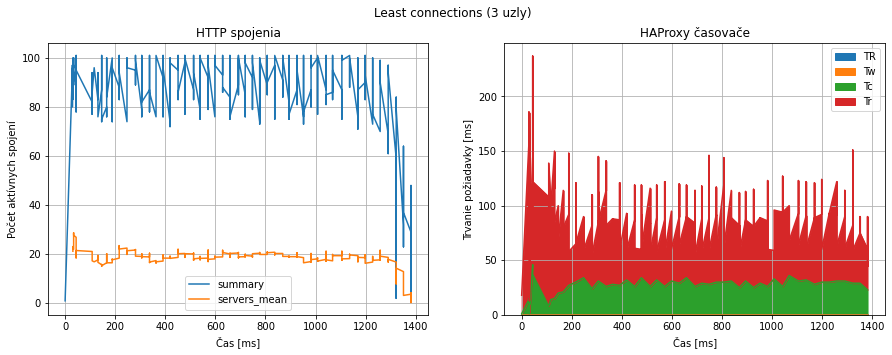

In [57]:
plot_haproxy_log(log, 'Least connections (3 uzly)')

In [58]:
log = haproxy_experiment('source-2/haproxy_ab_1000_100.log')
scheduling_matrix(log)

,B
B,1.000000


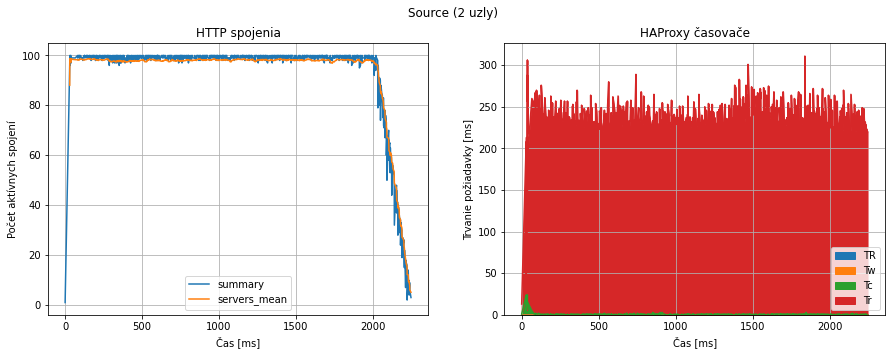

In [59]:
plot_haproxy_log(log, 'Source (2 uzly)')

In [60]:
log = haproxy_experiment('source-3/haproxy_ab_1000_100.log')
scheduling_matrix(log)

,C
C,1.000000


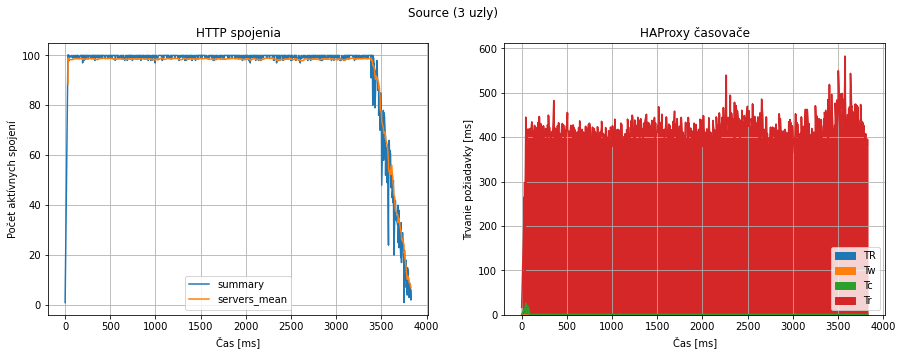

In [61]:
plot_haproxy_log(log, 'Source (3 uzly)')

---
# HAProxy (10000 spojení, 1000 paralelne)

In [62]:
log = haproxy_experiment('roundrobin-1/haproxy_ab_10000_1000.log')
scheduling_matrix(log)

,A
A,1.000000


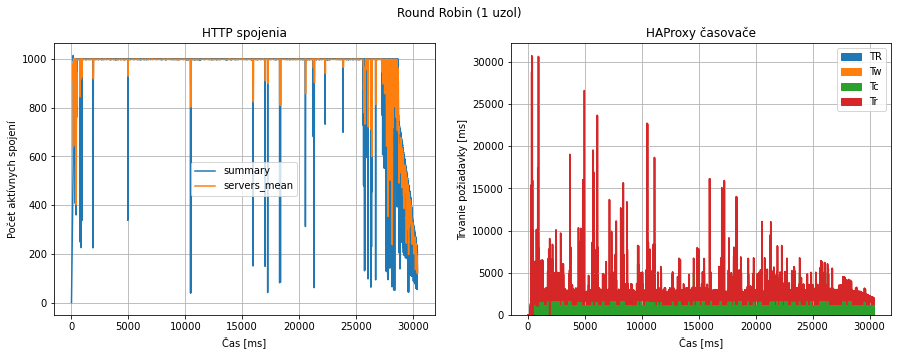

In [63]:
plot_haproxy_log(log, 'Round Robin (1 uzol)')

In [64]:
log = haproxy_experiment('roundrobin-2/haproxy_ab_10000_1000.log')
scheduling_matrix(log)

,A,B
A,0.177477,0.322022
B,0.322122,0.178378


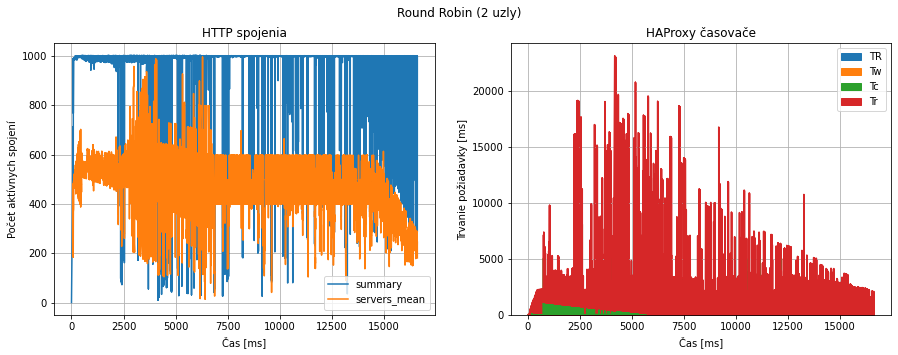

In [65]:
plot_haproxy_log(log, 'Round Robin (2 uzly)')

In [66]:
log = haproxy_experiment('roundrobin-3/haproxy_ab_10000_1000.log')
scheduling_matrix(log)

,A,B,C
A,0.129713,0.088109,0.115512
B,0.112811,0.130813,0.089709
C,0.090809,0.114411,0.128113


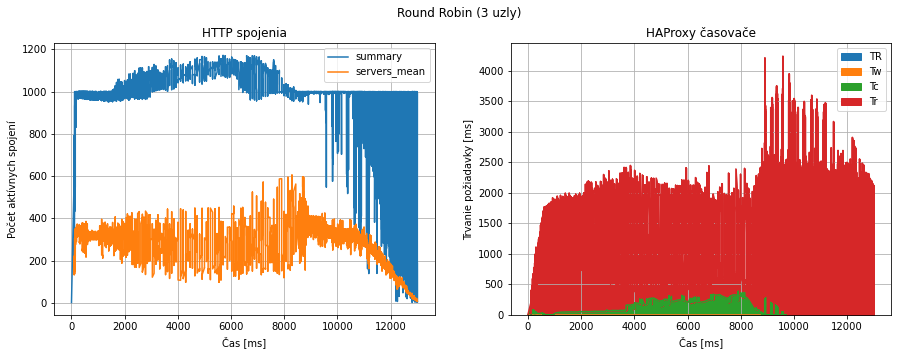

In [67]:
plot_haproxy_log(log, 'Round Robin (3 uzly)')

In [68]:
log = haproxy_experiment('roundrobin-weights/haproxy_ab_10000_1000.log')
scheduling_matrix(log)

,A,B,C
A,0.313596,0.256287,0.054403
B,0.264402,0.041579,0.007114
C,0.046388,0.015129,0.001102


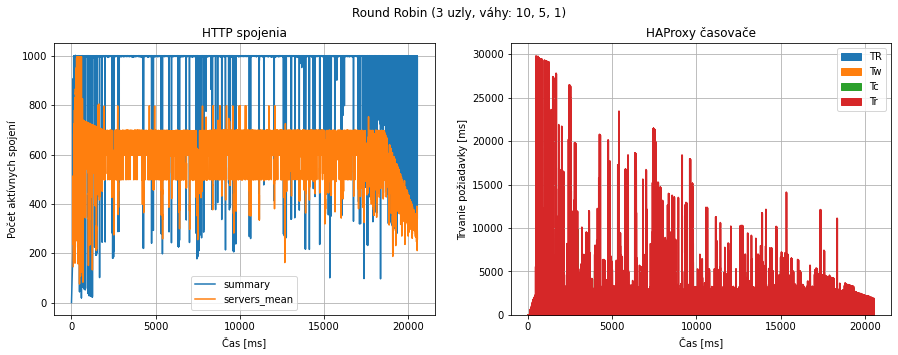

In [69]:
plot_haproxy_log(log, 'Round Robin (3 uzly, váhy: 10, 5, 1)')

In [70]:
log = haproxy_experiment('leastconn-2/haproxy_ab_10000_1000.log')
scheduling_matrix(log)

,A,B
A,0.112111,0.252225
B,0.252225,0.383438


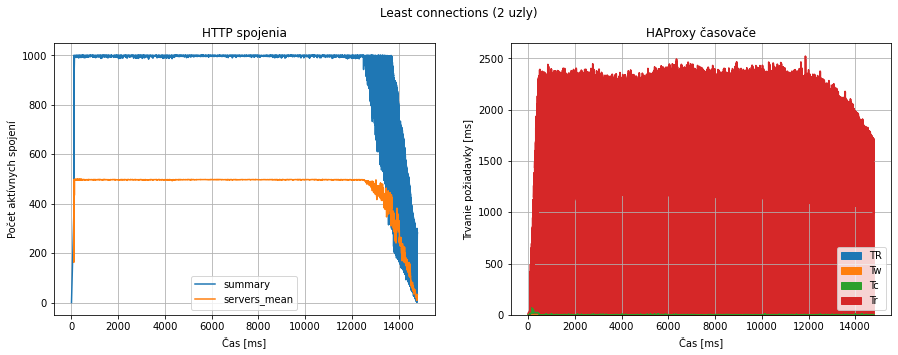

In [71]:
plot_haproxy_log(log, 'Least connections (2 uzly)')

In [72]:
log = haproxy_experiment('leastconn-3/haproxy_ab_10000_1000.log')
scheduling_matrix(log)

,A,B,C
A,0.049905,0.115512,0.072607
B,0.114111,0.215822,0.146315
C,0.073907,0.145015,0.066807


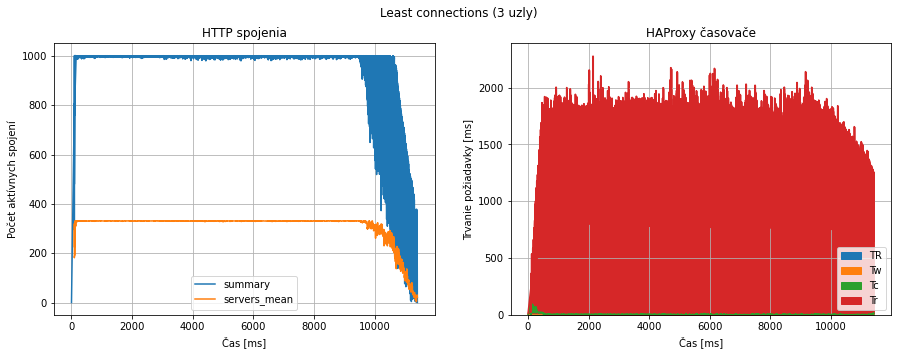

In [73]:
plot_haproxy_log(log, 'Least connections (3 uzly)')

In [74]:
log = haproxy_experiment('source-2/haproxy_ab_10000_1000.log')
scheduling_matrix(log)

,B
B,1.000000


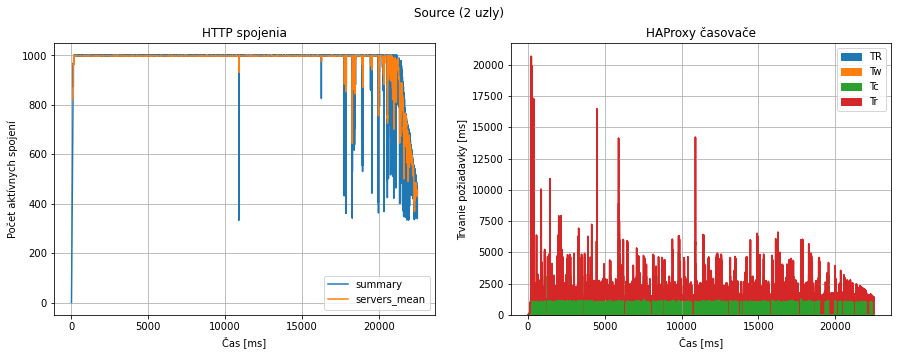

In [75]:
plot_haproxy_log(log, 'Source (2 uzly)')

In [76]:
log = haproxy_experiment('source-3/haproxy_ab_10000_1000.log')
scheduling_matrix(log)

,C
C,1.000000


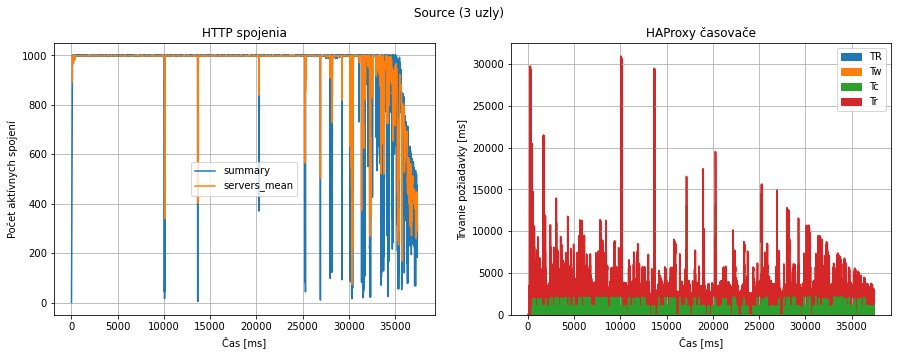

In [77]:
plot_haproxy_log(log, 'Source (3 uzly)')